# 2022-02-07 • Big-N-to-1 simulation

In [1]:
# Pkg.resolve()

In [2]:
include("nb_init.jl")

[ Info: using Revise
[ Info: import Distributions
[ Info: import PyPlot
[ Info: import DataFrames, PrettyTables
[ Info: import MyToolbox
[ Info: Precompiling MyToolbox [54cd1024-cafd-4d62-948d-ced4874502bf]
[ Info: using VoltageToMap
[ Info: Precompiling VoltageToMap [b3b8fdc5-3c26-4000-a0c8-f17415fdf48e]


In [3]:
using Parameters, ComponentArrays
@alias CArray = ComponentArray;

In [4]:
save(fname) = savefig(fname, subdir="methods");

## Parameters

In [6]:
sim_duration = 10 * seconds
Δt = 0.1 * ms;

### Input spikers

In [7]:
N_unconn = 100
N_exc    = 5200
N_inh    = N_exc ÷ 4

1300

In [8]:
N_conn = N_inh + N_exc

6500

In [9]:
N = N_conn + N_unconn

6600

In [10]:
input_spike_rate = LogNormal_with_mean(4Hz, √0.6)  # See the previous notebook

LogNormal{Float64}(μ=1.0862943611198905, σ=0.7745966692414834)

### Synapses

Reversal potential at excitatory and inhibitory synapses,  
as in the report [`2021-11-11__synaptic_conductance_ratio.pdf`](https://github.com/tfiers/phd-thesis/blob/main/reports/2021-11-11__synaptic_conductance_ratio.pdf):

In [11]:
v_exc =   0 * mV
v_inh = -65 * mV;

Exponential decay time constant of synaptic conductance `g`, $τ_{s}$ (`s` for "synaptic"):

In [12]:
τs =   7 * ms;

Synaptic conductances at `t = 0`:

In [13]:
g0 = 0 * nS;

### Izhikevich neuron

Membrane potential `v` and adaptation variable `u` at `t = 0`:

In [14]:
v0    = -80 * mV
u0    =   0 * pA;

Parameters for a cortical regular spiking neuron:

In [15]:
@with_kw struct IzhikevichParams
    C      = 100 * pF
    k      = 0.7 * (nS/mV)
    b      = -2 * nS
    v_r    = -60 * mV
    v_t    = -40 * mV
    v_peak =  35 * mV
    c      = -50 * mV
    a      = 0.03 / ms
    d      = 100 * pA
end

cortical_RS = IzhikevichParams();

## IDs

Simple here for the N-to-1 case: only input 'neurons' get an ID, and there is only one synapse for every (connected) neuron.

### Neuron IDs

In [16]:
neuron_ids = CArray(exc = 1:N_exc, inh = 1:N_inh, unconn = 1:N_unconn)

ComponentVector{Int64}(exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200], inh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300], unconn = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

In [17]:
only(getaxes(neuron_ids))

Axis(exc = 1:5200, inh = 5201:6500, unconn = 6501:6600)

In [22]:
resetrng!(797)
showsome(labels(neuron_ids))

seed = 797
6600-element Vector{String}:
    1: "exc[1]"
    2: "exc[2]"
    ⋮
 3012: "exc[3012]"
    ⋮
 5977: "inh[777]"
    ⋮
 6599: "unconn[99]"
 6600: "unconn[100]"


i.e. a neuron's **global** ID = its index into the [ComponentVector](https://github.com/jonniedie/ComponentArrays.jl) "`neuron_ids`".

### Synapse IDs

In [23]:
synapse_ids = CArray(exc = 1:N_exc, inh = 1:N_inh)

ComponentVector{Int64}(exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200], inh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300])

## Inputs

In [33]:
λ = rand(input_spike_rate, N)  # sample firing rates, one for every input neuron
β = 1 ./ λ                     # alternative Exp parametrisation: scale (= 1 / rate)
ISI_distributions = Exponential.(β);
#   This uses julia's broadcasting `.` syntax: make an `Expontential` distribution for every value in the β vector

In [34]:
# Create v_syn vector: for each neuron, the reversal potential at its downstream synapses.
vs = CArray(E=fill(v_exc, N_exc), I=fill(v_inh, N_inh))

ComponentVector{Float64}(E = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], I = [-0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065  …  -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065])

## Sim

Proof of concept of spike generation using a priority queue.

In [45]:
using DataStructures

first_spiketimes = rand.(ISI_distributions)

pq = PriorityQueue{Int, Float64}()
for (input_neuron, t) in enumerate(first_spiketimes)
    enqueue!(pq, input_neuron => t)
end

while t < sim_duration
    input_neuron, t = dequeue_pair!(pq)  # earliest spike
    new_ISI = rand(ISI_distributions[input_neuron])
    enqueue!(pq, input_neuron => t + new_ISI)
end

In [25]:
using OrdinaryDiffEq

In [87]:
function f(D, vars, params, _t)
    @unpack C, k, b, v_r, v_t, v_peak, c, a, d = params
    @unpack v, u, g = vars
    Is = sum(g .* (v .- vs))
    D.v = (k * (v - v_r) * (v - v_t) - u) / C
    D.u = a * (b * (v - v_r) - u)
    D.g = -g ./ τs
    return nothing
end

x0 = ComponentArray{Float64}(v = v0, u = u0, g = fill(g0, N_conn))  # Note eltype cast to float.
prob = ODEProblem(f, x0, float(sim_duration), cortical_RS)  # Time must also be float.
sol = solve(
    prob,
    Tsit5();          # The default solver. A Runge-Kutta method. Tsitouras 2011.
    dt = Δt,          # Size of first step.
    adaptive = true,  # Take larger steps when output is steady
    reltol = 1e-8,    # default: 1e-2
    abstol = 1e-8,    # default: 1e-6
);

Tolerances from https://diffeq.sciml.ai/stable/tutorials/ode_example/#Choosing-a-Solver-Algorithm and experimentation:  
Lower for either gives incorrect oscillations in steady state (non-todo: show this in a separate nb).

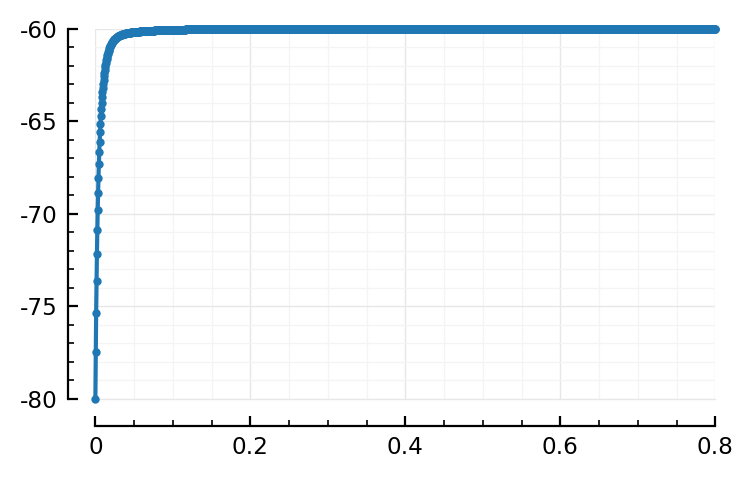

In [83]:
t = 0ms:0.5ms:0.8s
v = t -> sol(t).v / mV
plot(t, v.(t), clip_on=false, marker=".", ms=4);